# Effective DOF test

## Import package

In [1]:
import numpy as np
import netCDF4 as nc

from scipy import stats
from matplotlib.colors import TwoSlopeNorm
from matplotlib import pyplot as plt

## Load data

In [2]:
# Load MPAS data
## dimension
dims: dict[str, np.ndarray] = dict()

data: dict[str, np.ndarray] = dict()

## variables
with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/theta.nc", "r") as f:
    for key in f.dimensions.items():
        dims[key[0]] = f.variables[key[0]][:]

    lat_lim: list[int] = np.where((dims["lat"][:] >= -5) & (dims["lat"][:] <= 5))[0]

    data["temp"] = (f.variables["theta"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15

ltime, llev, llon = data["temp"].shape

with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/rthratenlw.nc", "r") as f:
    data["lw"] = ((f.variables["rthratenlw"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15) * 86400


with nc.Dataset("/work/b11209013/2024_Research/MPAS/merged_data/CNTL/rthratensw.nc", "r") as f:
    data["sw"] = ((f.variables["rthratensw"][:, :, lat_lim, :].mean(axis=2) * (1000/dims["lev"])[None, :, None]**(-0.286)) - 273.15) * 86400


# load events
lon_ref, time_ref = np.load(
        "/home/b11209013/2024_Research/MPAS/Composite/Q1_event_sel/Q1_sel/CNTL.npy"
    )

### Acquiring anomaly

In [3]:
for key in data.keys():
    data[key] -= data[key].mean(axis=(0, 2))[None, :, None]

## Systematic Event selection

### Time interval setting

In [4]:
time_itv = np.array([
        np.linspace(time_ref[i]-12, time_ref[i]+12, 25)
        for i in range(time_ref.shape[0])
    ])

### Event selection

In [5]:
data_sel: dict[str, np.ndarray] = dict()

for key in data.keys():
    data_sel[key] = np.array([
        data[key][time_itv[i].astype(int), :, lon_ref[i].astype(int)]
        for i in range(time_ref.shape[0])
    ]).mean(axis=0).T

for key in data_sel.keys():
    data_sel[key] = np.concatenate([
        (data_sel[key][:, :4].mean(axis=1))[:, None],
        (data_sel[key][:, 4:8].mean(axis=1))[:, None],
        (data_sel[key][:, 8:12].mean(axis=1))[:, None],
        (data_sel[key][:, 13:17].mean(axis=1))[:, None],
        (data_sel[key][:, 17:21].mean(axis=1))[:, None],
        (data_sel[key][:, 21:].mean(axis=1))[:, None],
    ], axis=1)

print(data_sel["temp"].shape)

(38, 6)


### Compositing

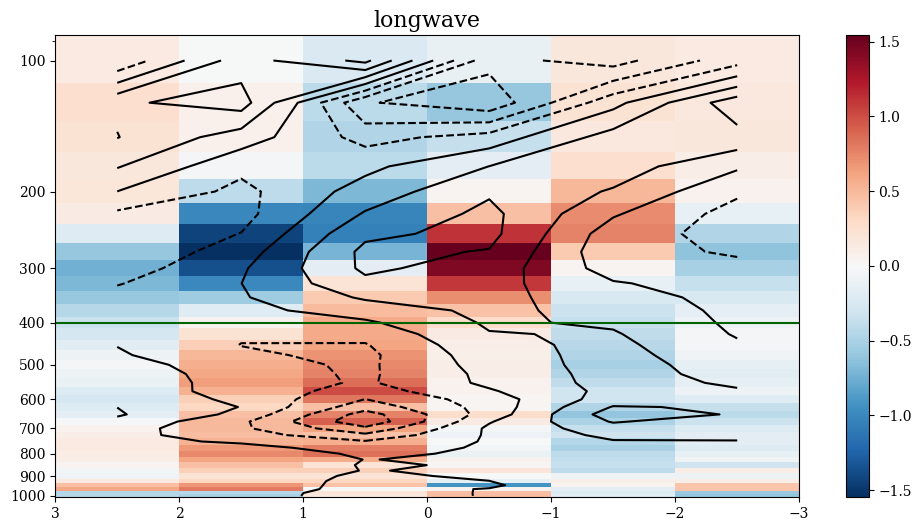

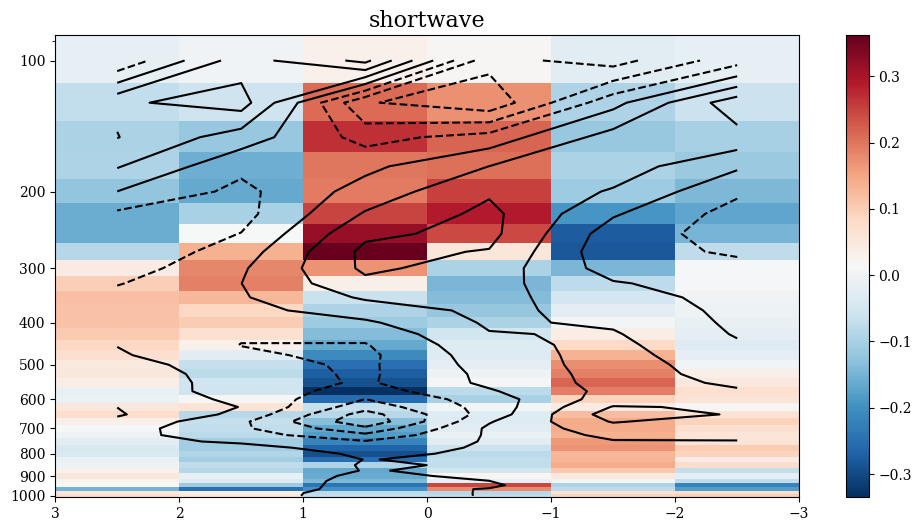

In [20]:
plt.figure(figsize=(12, 6))

pmesh = plt.pcolormesh(np.linspace(-2.5, 2.5, 6), dims["lev"], data_sel["lw"], cmap="RdBu_r")
plt.contour(np.linspace(-2.5, 2.5, 6), dims["lev"], data_sel['temp'], colors="black")
plt.axhline(400, color='darkgreen')
plt.yscale("log")
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title("longwave")
plt.colorbar(pmesh)
plt.savefig("raw_daily_longwave.png")
plt.show()

plt.figure(figsize=(12, 6))

pmesh = plt.pcolormesh(np.linspace(-2.5, 2.5, 6), dims["lev"], data_sel["sw"], cmap="RdBu_r")
plt.contour(np.linspace(-2.5, 2.5, 6), dims["lev"], data_sel['temp'], colors="black")
plt.yscale("log")
plt.yticks(np.linspace(100, 1000, 10), np.linspace(100, 1000, 10).astype(int))
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.title("shortwave")
plt.colorbar(pmesh)
plt.savefig("raw_daily_shortwave.png")
plt.show()

#### daily averaged

### Correlation

#### 300 hPa

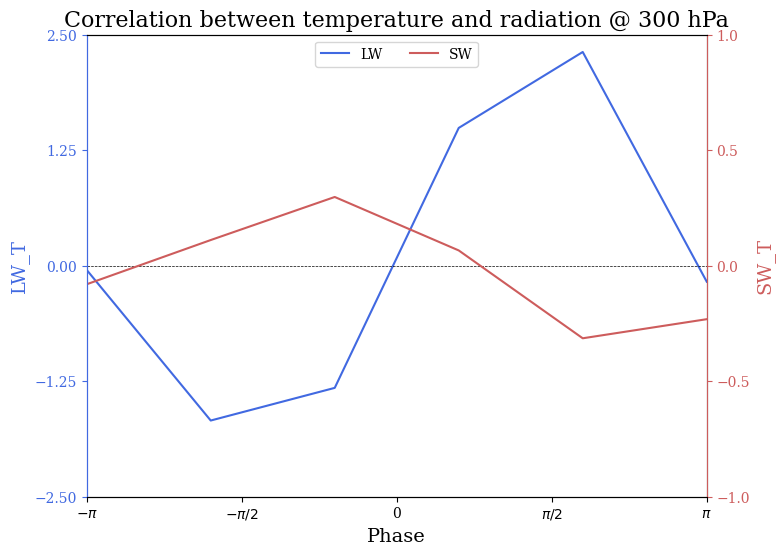

In [7]:
from cProfile import label


lw_t = np.empty((llev, 6))
sw_t = np.empty((llev, 6))

for i in range(llev):
    lw_t[i] = np.correlate(data_sel["temp"][i] - data_sel["temp"][i].mean(), data_sel["lw"][i] - data_sel["lw"][i].mean(),  mode="same")
    sw_t[i] = np.correlate(data_sel["temp"][i] - data_sel["temp"][i].mean(), data_sel["sw"][i] - data_sel["sw"][i].mean(),  mode="same")

lev_300 = np.argmin(np.abs(dims["lev"] - 300))

plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})

lw_str_idx = np.argmin(np.abs(lw_t[lev_300][1:] - lw_t[lev_300][0]))
sw_str_idx = np.argmin(np.abs(sw_t[lev_300][1:] - sw_t[lev_300][0]))

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot LW data (left axis)
lw_line, = ax1.plot(
    np.linspace(-np.pi, np.pi, len(lw_t[lev_300])),
    lw_t[lev_300], 
    label="LW", 
    color="royalblue"
)
ax1.axhline(0, color="black", linewidth=0.5, linestyle="--")
ax1.set_xticks(np.linspace(-np.pi, np.pi, 5), ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
ax1.set_yticks(np.linspace(-2.5, 2.5, 5))
ax1.set_xlim(-np.pi, np.pi)
ax1.set_ylim(-2.5, 2.5)
ax1.set_xlabel("Phase")
ax1.set_ylabel("LW_T", color="royalblue")  # Set label color
ax1.spines['left'].set_color('royalblue')  # Set left spine color
ax1.tick_params(axis="y", colors="royalblue")  # Set left tick color

# Plot SW data (right axis)
ax3 = ax1.twinx()
sw_line, = ax3.plot(
    np.linspace(-np.pi, np.pi, len(sw_t[lev_300])),
    sw_t[lev_300], 
    label="SW", 
    color="indianred"
)
ax3.set_yticks(np.linspace(-1, 1, 5))
ax3.set_ylim(-1, 1)
ax3.set_ylabel("SW_T", color="indianred")  # Set label color
ax3.spines['left'].set_color('royalblue')  # Set right spine color
ax3.spines['right'].set_color('indianred')  # Set right spine color
ax3.tick_params(axis="y", colors="indianred")  # Set right tick color

# Add a combined legend
lines = [lw_line, sw_line]
labels = [line.get_label() for line in lines]
ax3.legend(lines, labels, ncol=2, loc="upper center")  # Adjust location as needed

# Set title and save figure
plt.title("Correlation between temperature and radiation @ 300 hPa")
plt.savefig("raw_correlation_300hpa.png")
plt.show()


#### 400 hPa

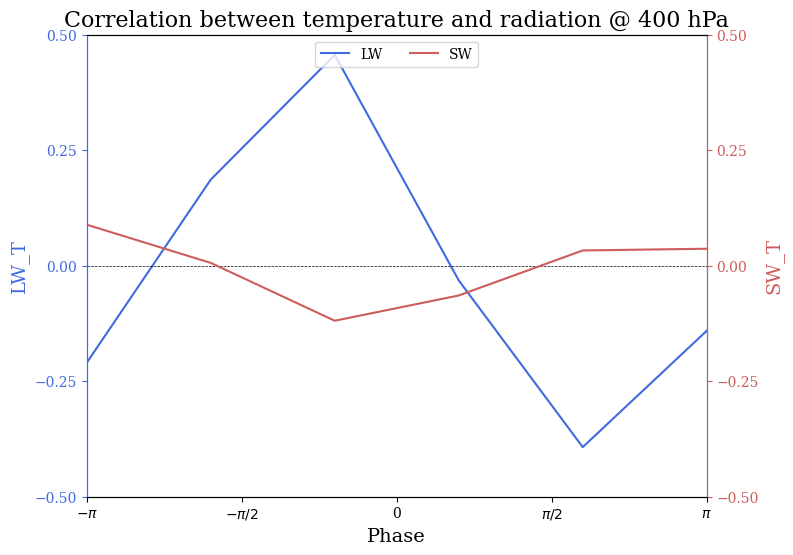

In [8]:
lev_400= np.argmin(np.abs(dims["lev"] - 400))

plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})

lw_str_idx = np.argmin(np.abs(lw_t[lev_400][1:] - lw_t[lev_400][0]))
sw_str_idx = np.argmin(np.abs(sw_t[lev_400][1:] - sw_t[lev_400][0]))

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot LW data (left axis)
lw_line, = ax1.plot(
    np.linspace(-np.pi, np.pi, len(lw_t[lev_400])),
    lw_t[lev_400], 
    label="LW", 
    color="royalblue"
)
ax1.axhline(0, color="black", linewidth=0.5, linestyle="--")
ax1.set_xticks(np.linspace(-np.pi, np.pi, 5), ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax1.set_xlim(-np.pi, np.pi)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel("Phase")
ax1.set_ylabel("LW_T", color="royalblue")  # Set label color
ax1.spines['left'].set_color('royalblue')  # Set left spine color
ax1.tick_params(axis="y", colors="royalblue")  # Set left tick color

# Plot SW data (right axis)
ax3 = ax1.twinx()
sw_line, = ax3.plot(
    np.linspace(-np.pi, np.pi, len(sw_t[lev_400])),
    sw_t[lev_400], 
    label="SW", 
    color="indianred"
)
ax3.set_yticks(np.linspace(-0.5, 0.5, 5))
ax3.set_ylim(-0.5, 0.5)
ax3.set_ylabel("SW_T", color="indianred")  # Set label color
ax3.spines['left'].set_color('royalblue')  # Set right spine color
ax3.spines['right'].set_color('indianred')  # Set right spine color
ax3.tick_params(axis="y", colors="indianred")  # Set right tick color

# Add a combined legend
lines = [lw_line, sw_line]
labels = [line.get_label() for line in lines]
ax3.legend(lines, labels, ncol=2, loc="upper center")  # Adjust location as needed

# Set title and save figure
plt.title("Correlation between temperature and radiation @ 400 hPa")
plt.savefig("raw_correlation_400hpa.png")
plt.show()

#### 850 hPa

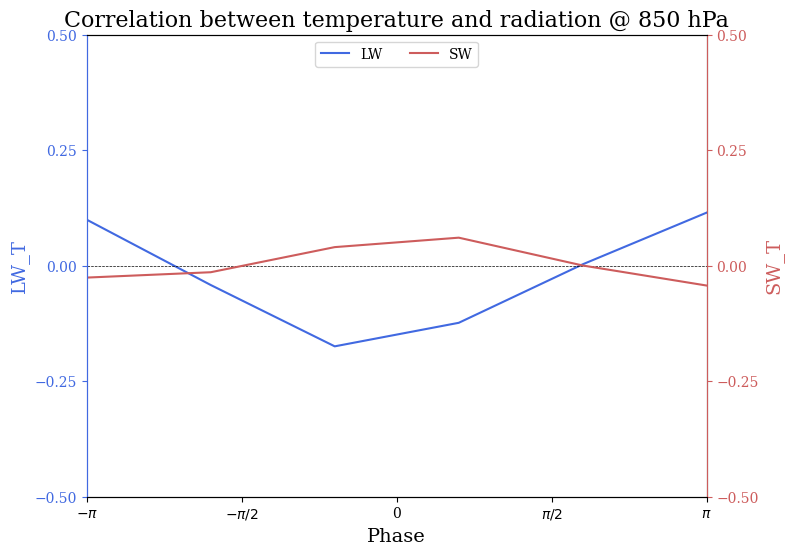

In [9]:
lev_850 = np.argmin(np.abs(dims["lev"] - 850))

plt.rcParams.update({
    'font.size': 10,
    'figure.titlesize': 16,
    'axes.titlesize': 16,
    'axes.labelsize': 14,
    'font.family': 'serif',
})

lw_str_idx = np.argmin(np.abs(lw_t[lev_850][1:] - lw_t[lev_850][0]))
sw_str_idx = np.argmin(np.abs(sw_t[lev_850][1:] - sw_t[lev_850][0]))

fig, ax1 = plt.subplots(figsize=(8, 6))

# Plot LW data (left axis)
lw_line, = ax1.plot(
    np.linspace(-np.pi, np.pi, len(lw_t[lev_850])),
    lw_t[lev_850], 
    label="LW", 
    color="royalblue"
)
ax1.axhline(0, color="black", linewidth=0.5, linestyle="--")
ax1.set_xticks(np.linspace(-np.pi, np.pi, 5), ["$-\pi$", "$-\pi/2$", "0", "$\pi/2$", "$\pi$"])
ax1.set_yticks(np.linspace(-0.5, 0.5, 5))
ax1.set_xlim(-np.pi, np.pi)
ax1.set_ylim(-0.5, 0.5)
ax1.set_xlabel("Phase")
ax1.set_ylabel("LW_T", color="royalblue")  # Set label color
ax1.spines['left'].set_color('royalblue')  # Set left spine color
ax1.tick_params(axis="y", colors="royalblue")  # Set left tick color

# Plot SW data (right axis)
ax3 = ax1.twinx()
sw_line, = ax3.plot(
    np.linspace(-np.pi, np.pi, len(sw_t[lev_850])),
    sw_t[lev_850], 
    label="SW", 
    color="indianred"
)
ax3.set_yticks(np.linspace(-0.5, 0.5, 5))
ax3.set_ylim(-0.5, 0.5)
ax3.set_ylabel("SW_T", color="indianred")  # Set label color
ax3.spines['left'].set_color('royalblue')  # Set right spine color
ax3.spines['right'].set_color('indianred')  # Set right spine color
ax3.tick_params(axis="y", colors="indianred")  # Set right tick color

# Add a combined legend
lines = [lw_line, sw_line]
labels = [line.get_label() for line in lines]
ax3.legend(lines, labels, ncol=2, loc="upper center")  # Adjust location as needed

# Set title and save figure
plt.title("Correlation between temperature and radiation @ 850 hPa")
plt.savefig("raw_correlation_850hpa.png")
plt.show()
